In [1]:
%matplotlib inline
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# depend on tensorflow 2
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Embedding, Conv1D, MaxPooling1D, AveragePooling1D, UpSampling1D
from tensorflow.keras.layers import Dropout, BatchNormalization, Activation, Flatten, Reshape, Dense
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.regularizers import l1, l2, l1_l2
from tensorflow.keras.utils import to_categorical

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, r2_score, mean_squared_error
from sklearn.utils.multiclass import unique_labels

# Set number of GPUs

In [2]:
import os
# Set environment variables
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

# On DGX-1 you might need to set the following environment variable for maximum performance:
os.environ['NCCL_TOPOLOGY'] = 'CUBEMESH'

In [3]:
# print out local devices visible to TensorFlow
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 6744369420518146607, name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 18228514678212114092
 physical_device_desc: "device: XLA_CPU device", name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 6372119866137173097
 physical_device_desc: "device: XLA_GPU device", name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 15651402548
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 15639841662228823311
 physical_device_desc: "device: 0, name: Tesla V100-SXM2-16GB, pci bus id: 0000:07:00.0, compute capability: 7.0"]

# Data

## load genotype

In [4]:
# get genotype col names
vcf_file = 'data/ADNI_JansenNG_33gene_unimputed.vcf'
with open(vcf_file, 'r') as f_vcf:
    while True:
        line = f_vcf.readline()
        if line[:2]!='##':
            break

    col_names = line[1:].split()
        
# print(col_names)

In [5]:
# load genotype
vcf_file = 'data/ADNI_JansenNG_33gene_unimputed.vcf'
vcf_genotype = pd.read_csv(
    vcf_file,
    sep='\t',
    header=None,
    names=col_names,
    comment='#')

vcf_genotype

,CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO,FORMAT,2_123_S_0108,...,2_141_S_1245,2_941_S_1194,2_941_S_1295,2_941_S_1311,2_941_S_1363,2_002_S_4264,2_021_S_2077,2_024_S_4186,2_128_S_2057,2_941_S_4066
0,1,161111931,rs10908824,A,G,.,.,PR,GT,0/0,...,0/1,1/1,0/0,0/0,0/1,0/1,0/0,0/0,0/1,0/0
1,1,161116022,rs11589567,G,T,.,.,PR,GT,0/0,...,0/1,1/1,0/0,0/0,0/1,0/1,0/0,0/0,0/1,0/0
2,1,161122903,rs4656988,G,A,.,.,PR,GT,0/1,...,0/1,1/1,0/1,0/0,0/1,0/1,0/1,0/1,0/1,0/0
3,1,161135421,rs3402,C,T,.,.,PR,GT,0/0,...,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0
4,1,161135559,rs2502806,G,A,.,.,PR,GT,0/0,...,0/1,0/0,0/1,0/0,0/1,0/1,0/1,0/1,0/1,0/0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1778,20,55057904,rs6064401,G,A,.,.,PR,GT,0/1,...,0/1,0/1,0/0,0/1,0/1,0/1,0/1,1/1,0/1,0/1
1779,20,55062564,rs6092321,A,G,.,.,PR,GT,0/0,...,0/0,0/1,1/1,0/1,0/0,0/0,0/0,0/0,0/1,0/1
1780,20,55072472,rs6024911,G,A,.,.,PR,GT,0/0,...,0/0,0/1,1/1,0/1,0/0,0/0,0/0,0/0,0/1,0/1
1781,20,55078533,rs3827108,T,C,.,.,PR,GT,0/1,...,0/1,0/0,0/0,0/0,0/1,0/1,0/1,0/0,0/0,0/0


In [6]:
# replace genotype with integers
vcf_int = vcf_genotype.replace({
    './.': np.NaN,
    '0/0': 0,
    '0/1': 1,
    '1/0': 1,
    '1/1': 2
})

vcf_int

,CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO,FORMAT,2_123_S_0108,...,2_141_S_1245,2_941_S_1194,2_941_S_1295,2_941_S_1311,2_941_S_1363,2_002_S_4264,2_021_S_2077,2_024_S_4186,2_128_S_2057,2_941_S_4066
0,1,161111931,rs10908824,A,G,.,.,PR,GT,0,...,1,2,0,0,1,1,0,0,1,0
1,1,161116022,rs11589567,G,T,.,.,PR,GT,0,...,1,2,0,0,1,1,0,0,1,0
2,1,161122903,rs4656988,G,A,.,.,PR,GT,1,...,1,2,1,0,1,1,1,1,1,0
3,1,161135421,rs3402,C,T,.,.,PR,GT,0,...,0,0,0,0,0,0,0,0,0,0
4,1,161135559,rs2502806,G,A,.,.,PR,GT,0,...,1,0,1,0,1,1,1,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1778,20,55057904,rs6064401,G,A,.,.,PR,GT,1,...,1,1,0,1,1,1,1,2,1,1
1779,20,55062564,rs6092321,A,G,.,.,PR,GT,0,...,0,1,2,1,0,0,0,0,1,1
1780,20,55072472,rs6024911,G,A,.,.,PR,GT,0,...,0,1,2,1,0,0,0,0,1,1
1781,20,55078533,rs3827108,T,C,.,.,PR,GT,1,...,1,0,0,0,1,1,1,0,0,0


In [7]:
# snp matrix with shape of (SNP loci, individual)
snp_ind_matrix = vcf_int.iloc[:, 9:]
snp_ind_matrix

,2_123_S_0108,2_024_S_0985,2_131_S_0123,2_098_S_0160,2_027_S_0256,2_116_S_1243,2_073_S_2264,2_094_S_2216,2_021_S_0337,2_141_S_1255,...,2_141_S_1245,2_941_S_1194,2_941_S_1295,2_941_S_1311,2_941_S_1363,2_002_S_4264,2_021_S_2077,2_024_S_4186,2_128_S_2057,2_941_S_4066
0,0,0,1,2,0,0,1,0,0,1,...,1,2,0,0,1,1,0,0,1,0
1,0,0,1,2,0,0,1,0,0,1,...,1,2,0,0,1,1,0,0,1,0
2,1,0,1,2,0,0,1,0,1,1,...,1,2,1,0,1,1,1,1,1,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,1,1,0,2,1,1,1,1,1,...,1,0,1,0,1,1,1,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1778,1,2,1,0,0,2,1,2,1,1,...,1,1,0,1,1,1,1,2,1,1
1779,0,0,0,0,1,0,0,0,0,1,...,0,1,2,1,0,0,0,0,1,1
1780,0,0,0,0,1,0,0,0,0,1,...,0,1,2,1,0,0,0,0,1,1
1781,1,0,1,2,1,0,1,0,1,0,...,1,0,0,0,1,1,1,0,0,0


In [8]:
# transposition is necessary.
ind_snp_matrix = snp_ind_matrix.transpose()
ind_snp_matrix

,0,1,2,3,4,5,6,7,8,9,...,1773,1774,1775,1776,1777,1778,1779,1780,1781,1782
2_123_S_0108,0,0,1,0,0,1,0,1,1,0,...,1,1,1,1,1,1,0,0,1,1
2_024_S_0985,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,2,0,0,0,2
2_131_S_0123,1,1,1,0,1,1,1,0,0,0,...,1,1,1,1,1,1,0,0,1,1
2_098_S_0160,2,2,2,0,0,2,2,0,0,2,...,2,2,2,2,2,0,0,0,2,0
2_027_S_0256,0,0,0,0,2,0,0,0,0,0,...,1,1,1,1,1,0,1,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2_002_S_4264,1,1,1,0,1,1,1,0,0,1,...,0,0,0,1,1,1,0,0,1,1
2_021_S_2077,0,0,1,0,1,1,1,0,0,0,...,1,1,1,1,1,1,0,0,1,1
2_024_S_4186,0,0,1,0,1,1,0,1,1,0,...,0,0,0,0,0,2,0,0,0,2
2_128_S_2057,1,1,1,0,1,1,1,0,0,0,...,0,0,0,0,0,1,1,1,0,1


## load phenotype

In [9]:
# load phenotype
ADAS_file = 'data/ADAS_selected.csv'
ADAS_data = pd.read_csv(ADAS_file, sep=',', header=0)
ADAS_data = ADAS_data.dropna()
ADAS_data

,RID,TOTSCORE,TOTAL13
0,31,5.0,10.0
1,35,6.0,13.0
2,47,8.0,14.0
3,51,9.0,20.0
4,58,5.0,10.0
...,...,...,...
930,5283,3.0,7.0
931,5287,3.0,4.0
932,5288,6.0,8.0
933,5290,5.0,6.0


In [10]:
ADAS_data[['TOTSCORE','TOTAL13']].describe()

,TOTSCORE,TOTAL13
count,930.000000,930.000000
mean,10.259140,16.009677
std,7.352463,10.353541
min,0.000000,0.000000
25%,5.000000,9.000000
50%,8.000000,13.000000
75%,13.000000,21.000000
max,52.000000,67.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ff03c098748>,
      dtype=object)

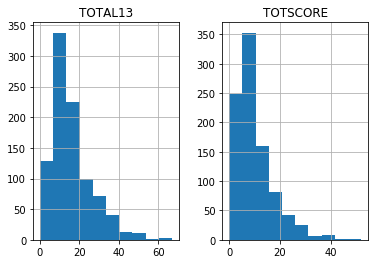

In [11]:
ADAS_data[['TOTSCORE','TOTAL13']].hist()

In [12]:
Y = np.asarray(ADAS_data['TOTSCORE'])

In [14]:
# normlization
Y = (Y - Y.min()) / (Y.max() - Y.min())

## Intersection

In [15]:
genetic_id = [x[-4:] for x in ind_snp_matrix.index]
rid = ['{:04d}'.format(x) for x in ADAS_data['RID']]

In [16]:
row_id = [genetic_id.index(x) for x in rid]

In [17]:
X = ind_snp_matrix.iloc[row_id, :]
X

,0,1,2,3,4,5,6,7,8,9,...,1773,1774,1775,1776,1777,1778,1779,1780,1781,1782
2_023_S_0031,1,1,1,0,1,1,1,0,0,1,...,2,2,2,2,2,0,0,0,2,0
2_100_S_0035,0,0,1,0,1,1,0,1,1,0,...,1,1,1,1,1,1,0,0,1,1
2_100_S_0047,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,1,1,1,0,1
2_099_S_0051,2,2,2,1,0,2,2,0,0,2,...,0,1,1,1,1,1,0,0,1,1
2_023_S_0058,0,0,0,0,2,0,0,0,0,0,...,1,0,0,0,0,1,1,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2_036_S_5283,2,2,2,1,0,2,2,0,0,2,...,1,2,2,2,2,0,0,0,2,0
2_053_S_5287,0,0,0,0,2,0,0,0,0,0,...,0,0,0,0,0,2,0,0,0,1
2_027_S_5288,0,0,0,0,2,0,0,0,0,0,...,1,1,1,1,1,1,0,0,1,1
2_024_S_5290,1,1,1,1,1,1,1,0,0,1,...,1,1,1,1,1,1,0,0,1,1


## Onehot encode

In [18]:
## One-hot encoding
X_onehot = to_categorical(X)
X_onehot.shape

(930, 1783, 3)

In [19]:
# # padding 1 for imputation 
# X_onehot_padding=np.pad(X_onehot,[[0,0],[0,1],[0,0]])
# X_onehot_padding.shape

## Split train and test

In [20]:
# split df to train and valid
X_train, X_test, Y_train, Y_test = train_test_split(
    X_onehot, Y, test_size=0.2)

X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((744, 1783, 3), (186, 1783, 3), (744,), (186,))

In [21]:
# split df to train and valid
X_train, X_valid, Y_train, Y_valid = train_test_split(
    X_train, Y_train, test_size=0.2)

X_train.shape, X_valid.shape, Y_train.shape, Y_valid.shape

((595, 1783, 3), (149, 1783, 3), (595,), (149,))

# Method 

## Build model

In [22]:
# hyperparameters
batch_size = 16
learning_rate = 0.001
epochs = 100

# conv 1D
num_kernels = 16
feature_size = X_train.shape[1]
inChannel = X_train.shape[2]
kr = 1e-4
drop_prec = 0.50

In [23]:
regressor = Sequential()

regressor.add(
    Conv1D(num_kernels,
           5,
           padding='same',
           activation='relu',
           kernel_regularizer=l1(kr),
           input_shape=(feature_size, inChannel)))
regressor.add(BatchNormalization())
regressor.add(AveragePooling1D(pool_size=2))
# regressor.add(Dropout(drop_prec))

regressor.add(Flatten())
regressor.add(Dense(feature_size, activation='relu',
                    kernel_regularizer=l1(kr)))
regressor.add(BatchNormalization())
# regressor.add(Dropout(drop_prec))

regressor.add(
    Dense(int(feature_size / 2), activation='relu', kernel_regularizer=l1(kr)))
regressor.add(BatchNormalization())
regressor.add(Dense(1))

#compile
regressor.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse'])

# optimizer=tf.keras.optimizers.Adam(learning_rate)

#summary
regressor.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 1783, 16)          256       
_________________________________________________________________
batch_normalization (BatchNo (None, 1783, 16)          64        
_________________________________________________________________
average_pooling1d (AveragePo (None, 891, 16)           0         
_________________________________________________________________
flatten (Flatten)            (None, 14256)             0         
_________________________________________________________________
dense (Dense)                (None, 1783)              25420231  
_________________________________________________________________
batch_normalization_1 (Batch (None, 1783)              7132      
_________________________________________________________________
dense_1 (Dense)              (None, 891)               1

## Training

In [24]:
regressor_fit = regressor.fit(
    X_train,
    Y_train,
    shuffle=True,
    batch_size=batch_size,
    epochs=epochs,
    verbose=1,
    validation_data=(X_valid, Y_valid),
    # callbacks=[EarlyStopping, ModelCheckpoint]
)

Train on 595 samples, validate on 149 samples
Epoch 1/100
595/595 [==============================] - 6s 11ms/sample - loss: 45.3342 - mse: 15.6474 - val_loss: 32.0780 - val_mse: 1.3974
Epoch 2/100
595/595 [==============================] - 0s 526us/sample - loss: 34.7758 - mse: 3.9614 - val_loss: 31.1267 - val_mse: 0.3540
Epoch 3/100
595/595 [==============================] - ETA: 0s - loss: 32.2218 - mse: 1.61 - 0s 522us/sample - loss: 32.1890 - mse: 1.5877 - val_loss: 30.4406 - val_mse: 0.0687
Epoch 4/100
595/595 [==============================] - 0s 535us/sample - loss: 30.6902 - mse: 0.5673 - val_loss: 29.9218 - val_mse: 0.0976
Epoch 5/100
595/595 [==============================] - 0s 524us/sample - loss: 29.7532 - mse: 0.2253 - val_loss: 29.2389 - val_mse: 0.0549
Epoch 6/100
595/595 [==============================] - 0s 511us/sample - loss: 29.0132 - mse: 0.1615 - val_loss: 28.5325 - val_mse: 0.0546
Epoch 7/100
595/595 [==============================] - 0s 523us/sample - loss: 28.

595/595 [==============================] - 0s 542us/sample - loss: 2.5803 - mse: 0.0156 - val_loss: 2.5217 - val_mse: 0.0212
Epoch 60/100
595/595 [==============================] - 0s 538us/sample - loss: 3.1406 - mse: 0.0191 - val_loss: 3.1755 - val_mse: 0.0261
Epoch 61/100
595/595 [==============================] - 0s 535us/sample - loss: 3.9065 - mse: 0.0271 - val_loss: 3.7706 - val_mse: 0.0390
Epoch 62/100
595/595 [==============================] - 0s 547us/sample - loss: 3.4076 - mse: 0.0244 - val_loss: 2.9875 - val_mse: 0.0235
Epoch 63/100
595/595 [==============================] - 0s 544us/sample - loss: 2.6858 - mse: 0.0179 - val_loss: 2.4287 - val_mse: 0.0201
Epoch 64/100
595/595 [==============================] - 0s 552us/sample - loss: 2.3836 - mse: 0.0144 - val_loss: 2.2421 - val_mse: 0.0209
Epoch 65/100
595/595 [==============================] - 0s 558us/sample - loss: 2.1807 - mse: 0.0169 - val_loss: 2.0749 - val_mse: 0.0203
Epoch 66/100
595/595 [=========================

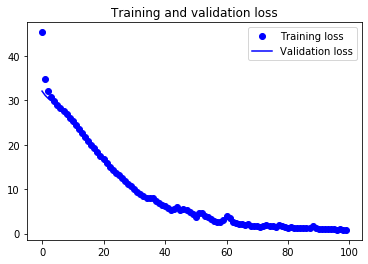

In [25]:
# plot loss curve on validation data
loss = regressor_fit.history['loss']
val_loss = regressor_fit.history['val_loss']

plt.figure()
plt.plot(range(len(loss)), loss, 'bo', label='Training loss')
plt.plot(range(len(val_loss)), val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

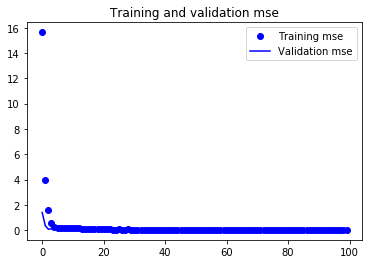

In [26]:
# plot accuracy curve on validation data
mse = regressor_fit.history['mse']
val_mse = regressor_fit.history['val_mse']
plt.figure()
plt.plot(range(len(mse)), mse, 'bo', label='Training mse')
plt.plot(range(len(val_mse)), val_mse, 'b', label='Validation mse')
plt.title('Training and validation mse')
plt.legend()
plt.show()

# Prediction

In [27]:
# predict
Y_predict = regressor.predict(X_test)

In [28]:
len(Y_test)

186

In [29]:
# r_square
r2_score(Y_test,Y_predict[:,0])

-0.8092412511928841

In [30]:
mean_squared_error(Y_test,Y_predict[:,0])

0.025998742973293305

# Plot

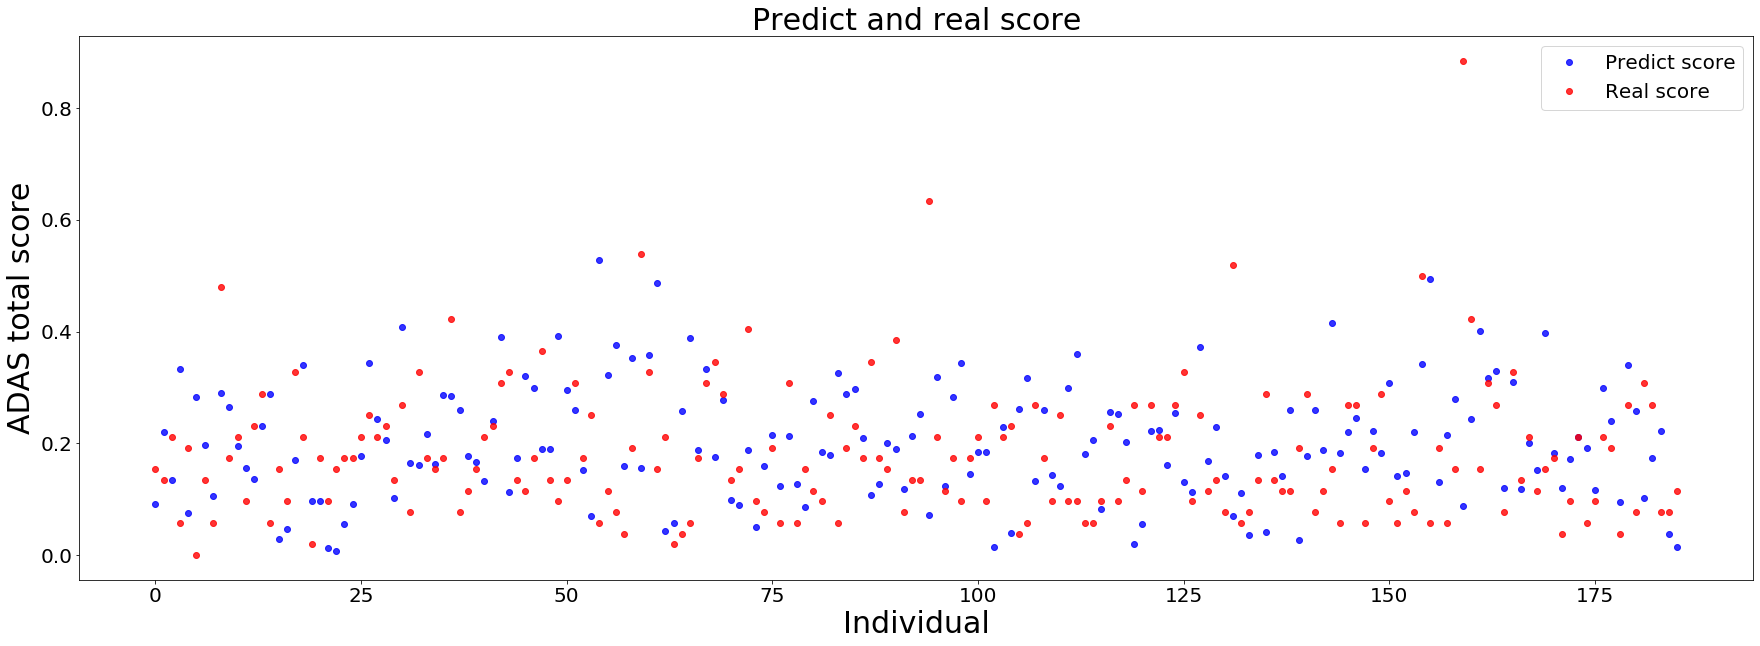

In [31]:
plt.figure(figsize=(30, 10))
plt.plot(range(len(Y_test)), Y_predict, 'bo', alpha=0.8, label='Predict score')
plt.plot(range(len(Y_test)), Y_test, 'ro', alpha=0.8, label='Real score')
plt.legend(fontsize=20)
plt.tick_params(labelsize=20)

plt.title('Predict and real score', fontsize=30)
plt.xlabel('Individual', fontsize=30)
plt.ylabel('ADAS total score', fontsize=30)
plt.show()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fefec22eb38>]],
      dtype=object)

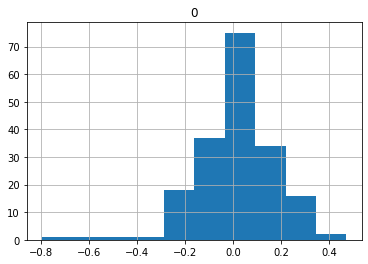

In [32]:
# difference histgram
diff=(Y_predict[:,0]-Y_test)
pd.DataFrame(diff).hist()